### Gaussian Mixture Models: Expectation-Maximization

#### References:
- [Mixture Models](https://github.com/paulaceccon/courses/blob/main/machine_learning_specialization/4_unsupervisioned_clustering/3_mixture_models-expectation_maximization.pdf)
- [Scikit-Learn Gaussian Mixture Models](https://scikit-learn.org/stable/modules/mixture.html)
- [K-Means Assumptions](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py)

<a href="https://colab.research.google.com/github/paulaceccon/dl-from-scratch/blob/main/notebooks/expectation_maximization.ipynb" target="_parent" style="float: left;"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs

%matplotlib inline

In [2]:
rng = np.random.RandomState(42)
X_train, y_train = make_blobs(
    n_samples=400, centers=4, cluster_std=0.60, random_state=0
)
X_test = np.array([[-2, 8], [-2, 1.5], [0, 6], [2, 6], [2, 2]])

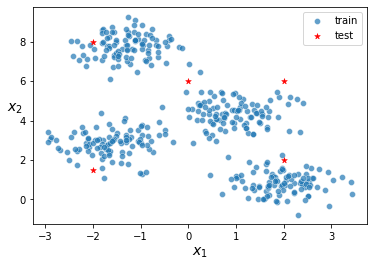

In [3]:
sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], alpha=0.7, label="train")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
sns.scatterplot(
    x=X_test[:, 0],
    y=X_test[:, 1],
    label="test",
    edgecolor=None,
    marker="*",
    color="red",
);

#### Idea

Each mixture component represents a unique cluster specified by: $\{\pi_k, \mu_k, \sum_k\}$, where $\pi_k$ is the weight associated with the Guassian component $k$, and a Gaussian Distribution, in 2D, is fully specified by $\mu$ and $\Sigma$, which can be expressed as $N(\mu, \Sigma)$. Then:

$0 \leq \pi_k \leq 1$ and $\sum_{k=1}^K \pi_k = 1$

- Prior probability: 

$p(z_i = k) = \pi_k$

- Likelihood: 

$p(x_i | z_i = k, \mu_k, \sum_k) = N(x_i | \mu_k, \sum_k)$


#### Model

1. E-Step
    
    1.1 Estimate cluster responsibilites $\hat{r}$ given current paramenter estimates.
    
    1.2 Compute the value of the PDF of the Gaussian distribution at each data point. Use the mean vector and covariance matrix as parameters of the Gaussian distribution.

    1.3 Multiply the PDF value by the cluster weight. This is the likelihood measure.

    1.4 Normalize all likelihood measures.

$ \hat{r}_{i,k} = \frac{ \hat{\pi}_k N(x_i | \hat{\mu_k}, \hat{\sum_k}) }{ \sum_{j=1}^k \hat{\pi} N(x_i | \hat{\mu}_j, \hat{\sum}_j) } $

2. M-Step

    For each cluster k in clusters:
        2.1 Update the weight for cluster k.   
        2.2 Update means for cluster k.
        2.3 Update covariances for cluster k.
        

 $N^{soft}_k = \sum_{i=1}^N r_{i,k}$
 
 $\hat{\pi}_k = \frac{N^{soft}_k}{N}$
 
 $\hat{\mu}_k = \frac{\sum_{i=1}^N r_{i,k} x_i}{N^{soft}_k}$
 
 $\hat{\Sigma}_k = \frac{\sum_{i=1}^N r_{i,k} (x_i-\hat{\mu} k)(x_i-\hat{\mu} k)^T}{N^{soft}_k}$

In [8]:
class ExpectationMaximization:
    """
    Implements a basic Expectation-Maximization algorithm.
    Initial parameters will be randomly initizalized.

    Args:
        n_clusters: number of clusters.
    """

    def __init__(self, n_clusters: int = 3):
        self._n_clusters: int = n_clusters
        self._weights: list[float]
        self._means: list[float]
        self._covs: np.ndarray
        self._X: np.ndarray = None
        self._X_num: int = 0
        self._X_dim: int = 0

    def fit(self, X: np.ndarray) -> None:
        """Fits the E-M."""
        self._X = X
        self._X_num = len(self._X)
        self._X_dim = len(self._X[0])

        self._initialize()
        self._train()

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Obtain the responsibilities of each cluster for each point in X."""
        return self._e_step(X)

    def _train(self, max_iter: int = 1000, thresh: float = 1e-4):
        """Performs the E-M steps until convergence."""
        ll = self._loglikelihood()
        ll_trace = [ll]

        for i in range(max_iter):
            if i % 5 == 0:
                print(f"Iteration {i}")

            resp = self._e_step(self._X)
            self._m_step(resp)

            ll_latest = self._loglikelihood()
            ll_trace.append(ll_latest)

            if (ll_latest - ll) < thresh and ll_latest > -np.inf:
                break

            ll = ll_latest

    def _initialize(self) -> None:
        """Randomly initizalize model parameters."""
        chosen = np.random.choice(self._X_num, self._n_clusters, replace=False)
        self._means = [self._X[x] for x in chosen]
        self._covs = [np.cov(self._X, rowvar=0)] * self._n_clusters
        self._weights = [1.0 / self._n_clusters] * self._n_clusters

    def _e_step(self, X: np.ndarray) -> np.ndarray:
        """
        Estimate cluster responsibiliteis given the current
        parameter estimates, so that resp[j, k] is the responsibility
        of cluster k for data point j.
        """
        X_num = len(X)
        resp = np.zeros((X_num, self._n_clusters))
        for j in range(X_num):
            for k in range(self._n_clusters):
                resp[j, k] = self._weights[k] * multivariate_normal.pdf(
                    X[j], self._means[k], self._covs[k]
                )

        row_sums = resp.sum(axis=1)[:, np.newaxis]
        resp = resp / row_sums  # normalize over all possible cluster assignments

        return resp

    def _m_step(self, resp: np.ndarray) -> None:
        """
        Maximize likelihood over parameters given responsibilities.

        Algorithm:
            For each cluster k in clusters:
                1. Update the weight for cluster k.
                2. Update means for cluster k.
                3. Update covariances for cluster k.
        Args:
            resp: responsibilit matrix.
        """
        soft_counts = np.sum(resp, axis=0)
        for k in range(self._n_clusters):
            # Weights
            self._weights[k] = soft_counts[k] / self._n_clusters

            # Means
            weighted_sum = sum(resp[j, k] * self._X[j] for j in range(self._X_num))
            self._means[k] = weighted_sum / soft_counts[k]

            # Covariances
            weighted_sum = np.zeros((self._X_dim, self._X_dim))
            for j in range(self._X_num):
                weighted_sum += resp[j, k] * np.outer(
                    self._X[j] - self._means[k], self._X[j] - self._means[k]
                )
            self._covs[k] = weighted_sum / soft_counts[k]

    def _log_sum_exp(self, Z: np.ndarray) -> np.ndarray:
        r"""Compute log(\sum_i exp(Z_i)) for some array Z."""
        return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

    def _loglikelihood(self) -> float:
        """Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters."""
        ll = 0
        for x in self._X:

            Z = np.zeros(self._n_clusters)
            for k in range(self._n_clusters):

                # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
                delta = np.array(x) - self._means[k]
                exponent_term = np.dot(
                    delta.T, np.dot(np.linalg.inv(self._covs[k]), delta)
                )

                # Compute loglikelihood contribution for this data point and this cluster
                Z[k] += np.log(self._weights[k])
                Z[k] -= (
                    1
                    / 2.0
                    * (
                        self._X_dim * np.log(2 * np.pi)
                        + np.log(np.linalg.det(self._covs[k]))
                        + exponent_term
                    )
                )

            # Increment loglikelihood contribution of this data point across all clusters
            ll += self._log_sum_exp(Z)

        return ll

In [9]:
n_clusters = 4
clf = ExpectationMaximization(n_clusters=n_clusters)
clf.fit(X_train)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30


In [10]:
predictions = clf.predict(X_test)

In [11]:
def draw_pie(dist: np.array, pos: tuple[int, int], size: int, colors: np.ndarray, ax):
    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum / cumsum[-1]
    pie = [0] + cumsum.tolist()

    xpos = pos[0]
    ypos = pos[1]

    for i, zipped_r in enumerate(zip(pie[:-1], pie[1:])):
        r1, r2 = zipped_r
        angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
        x = [0] + np.cos(angles).tolist()
        y = [0] + np.sin(angles).tolist()

        xy = np.column_stack([x, y])
        ax.scatter([xpos], [ypos], marker=xy, s=size, zorder=3, color=colors[i])

In [12]:
def plot_clusters(
    data: np.ndarray,
    means: np.ndarray,
    covs: np.ndarray,
    test_data: np.ndarray,
    test_predictions: np.ndarray,
) -> None:
    fig, ax = plt.subplots()
    ax.plot([x[0] for x in data], [y[1] for y in data], "ko", zorder=1, alpha=0.6)
    k = len(means)

    h = 0.02  # step size in the mesh
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    colors = [
        np.random.rand(
            3,
        )
        for i in range(k)
    ]  # random colors
    for i in range(k):
        mean = means[i]
        cov = covs[i]

        rv = multivariate_normal(mean, cov)
        Z = rv.pdf(np.dstack((xx, yy)))
        ax.contour(xx, yy, Z, zorder=2, colors=[colors[i]])

    for pos, prediction in zip(test_data, test_predictions):
        draw_pie(prediction, pos, 300, colors, ax)

    plt.title("Expectation Maximization")
    plt.rcParams.update({"font.size": 16})
    plt.tight_layout()

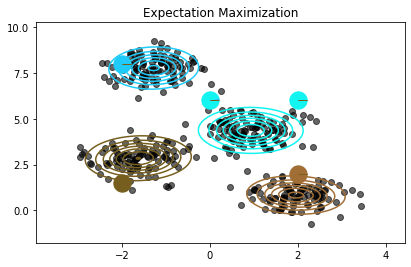

In [13]:
plot_clusters(clf._X, clf._means, clf._covs, X_test, predictions)